In [ ]:
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt

from tqdm import tqdm
from google.colab import auth
from google.cloud import storage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               FixedLocator, IndexLocator, LinearLocator)
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

## Install and import geopandas, rasterio, GCS file storage system
!pip install geopandas
import geopandas as gpd

!pip install rasterio
import rasterio
from rasterio.mask import mask

!pip install gcsfs

In [ ]:
## Authentication and global strings cell

# Authenticate Google account
auth.authenticate_user()

# Define bucket
bucket_name = 'gee_irrigation_detection'

# Define UTM CRS
utm_crs = 'EPSG:4326'

# Irrig year
year = 2021

# Define irrigation boolean
irrig_bool = False
if irrig_bool:
    irrig_str = 'irrig'
else:
    irrig_str = 'noirrig'

# Define whether to convert tifs to raw CSVs
create_raw_csvs = True

# Define storage client
storage_client = storage.Client()

# Define train/val/test splits
splits = [0.7, 0.15, 0.15]
configs = ['train', 'val', 'test']

In [ ]:
# Define temporal interpolation and smoothing function

def temporal_interp_and_smoothing(imagery_stack):
    # Pad imagery for interpolation
    imagery_stack = np.concatenate([imagery_stack[:, -1::], imagery_stack,
                                    imagery_stack[:, 0:1]], axis=1)

    # Convert to df
    df = pd.DataFrame(imagery_stack)

    # Change 0s to NaNs for interpolation
    df = df.replace(0, np.nan)

    # Interpolate. Will leave any all-NaN row as is
    df = df.interpolate(method='linear', axis=1)

    # Extract original timeseries
    interpolated_ts = df.iloc[:, 1:-1]

    # Smooth
    smoothed_ts = savgol_filter(interpolated_ts,
                                window_length=5,
                                polyorder=3,
                                axis=1)


    # Fill all remaining NaNs with zeros
    smoothed_ts = np.nan_to_num(smoothed_ts, nan=0)

    # Convert to float 32
    smoothed_ts = smoothed_ts.astype(np.float32)

    # Clip
    smoothed_ts = np.clip(smoothed_ts, 0, 1)

    # Returns array of size (window_width*window_height, 36)
    return smoothed_ts

In [ ]:
# Create csvs from uploaded tifs if accessing labeled data for the first time
if create_raw_csvs:
    prefix = f'raw_imagery/imagery_for_labels/BF/{irrig_str}'
    # prefix = f'raw_imagery/imagery_for_labels/tana_10k/{irrig_str}'

    # Load tifs
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix)
    raw_images = [blob.name for blob in blobs if '.tif' in blob.name]

    # Shuffle and split into train/val/test configs
    np.random.seed(10)
    np.random.shuffle(raw_images)

    # Split tifs into the configs so there's no data poisoning
    tifs_by_config = [raw_images[0:int(splits[0]*len(raw_images))],
                      raw_images[int(splits[0]*len(raw_images)): int((splits[0]+splits[1])*len(raw_images))],
                      raw_images[int((splits[0]+splits[1])*len(raw_images)): int((splits[0]+splits[1]+splits[2])*len(raw_images))],
                    ]

    # Load polygons
    polygons_filename = f'gs://{bucket_name}/shapefiles/BF_{irrig_str}_HS.geojson'
    # polygons_filename = f'gs://{bucket_name}/shapefiles/tana_10k_{irrig_str}_2020.geojson'
    gdf = gpd.read_file(polygons_filename).to_crs(utm_crs)

    for ix, config in enumerate(configs):
        tif_subset = tifs_by_config[ix]

        timeseries_list = []
        for image in tqdm(tif_subset):
            image_uri = f'gs://{bucket_name}/{image}'
            print(image_uri)
            with rasterio.open(image_uri, 'r') as src:
                img, _ = mask(src, gdf['geometry'], nodata=np.nan)

                # Reshape and transpose
                img = img.reshape(img.shape[0], img.shape[1]*img.shape[2]).T
                # print(img)
                img = img[~np.any(np.isnan(img), axis=1)]
                # print(img)

                # Interpolate and smooth
                smoothed_ts = temporal_interp_and_smoothing(img)

                timeseries_list.append(smoothed_ts)


        concat_list = np.concatenate(timeseries_list, axis=0)

        out_str = f'gs://{bucket_name}/cleaned_labeled_timeseries/csvs/BF/{irrig_str}/{config}/raw_{irrig_str}_timeseries.csv'
        pd.DataFrame(concat_list).to_csv(out_str)

        print(f'Total number of {irrig_str} samples in {config}: {len(concat_list)}')

#### Begin cluster cleaning

In [ ]:
# Define colors and plotting settings
colors_xkcd = [ 'very dark purple', "windows blue", "amber", "greyish",
                   "faded green", 'pastel blue', 'terracotta', 'grape', 'dark turquoise',
                   'salmon pink',]# 'evergreen', 'royal blue', 'dark red'

cmap = sns.color_palette(sns.xkcd_palette(colors_xkcd), desat=1)
cmap_base = sns.color_palette(sns.xkcd_palette(colors_xkcd), desat=0.4)
sns.set_palette(sns.xkcd_palette(colors_xkcd))

In [ ]:
def return_csvs(ts_type):
    '''
    Args:
        ts_type: Either "raw" or "cleaned".
    '''

    cleaned_ts_by_config = []
    # Load csvs by config
    for config in configs:
        file_str = f'gs://{bucket_name}/cleaned_labeled_timeseries/csvs/BF/{irrig_str}/{config}/{ts_type}_{irrig_str}_timeseries.csv'
        cleaned_ts_by_config.append(pd.read_csv(file_str, index_col=0))

    merged_data = np.concatenate(cleaned_ts_by_config, axis=0)
    num_samples_per_config = [len(i) for i in cleaned_ts_by_config]

    # print(f'Num samples per config: {num_samples_per_config}')

    return merged_data, num_samples_per_config

In [ ]:
def return_plot_figure():
    '''
    Return figure for plotting
    '''
    fig, ax = plt.subplots(figsize=(12,9))
    # ticknames = [f'Aug {year-1}', f'Oct {year-1}',
    #              f'Dec {year-1}', f'Feb {year}', f'Apr {year}', f'Jun {year-1}']
    ticknames = [f'Jan {year}', f'Mar {year}', f'May {year}',
                 f'Jul {year}', f'Sep {year}', f'Nov {year}']
    minors = np.linspace(0, 36, 37)
    fs = 12
    ax.set_ylabel(f'EVI', fontsize=fs)
    ax.set_xticklabels(ticknames, rotation=40, fontsize=fs)
    ax.xaxis.set_major_locator(IndexLocator(6, 0))
    ax.xaxis.set_minor_locator(FixedLocator(minors))
    ax.tick_params(axis='both', which='major', length=5, labelsize=fs)
    ax.tick_params(axis='x', which='minor', length=3)
    ax.grid(True)

    return fig, ax

In [ ]:
def clean_clusters(ts_type, save_new):
    '''
    Args:
        ts_type: Either "raw" or "cleaned".
    '''

    # Collect CSV data
    merged_data, n_per_config = return_csvs(ts_type)

    # Define number of clusters and PCA components
    n_clusters = 20
    n_pca_components = 10

    # Determine PCA transform
    pca = PCA(n_components=n_pca_components)
    principalComponents = pca.fit_transform(merged_data)

    # Apply GMM onto PC transformed data
    X = principalComponents
    gmm = GaussianMixture(n_components=n_clusters,
                            covariance_type='full')
    ylabels = gmm.fit_predict(X)

    # Set up the plot
    fig, ax = return_plot_figure()
    plt.ion()
    ax.set_title(f'Total {irrig_str.capitalize()} Pixels: {len(merged_data)}', fontsize=12)

    # Iterate through GMM clusters, plotting the mean of each
    for jx in range(n_clusters):
        valid_indices = np.where(ylabels == jx)[0]
        cluster_data = merged_data[valid_indices]

        vi_mean = np.clip(np.mean(cluster_data, axis=0), 0, 1)

        if jx >= 10:
            linestyle = '--'
        else:
            linestyle = '-'

        ax.plot(range(len(vi_mean)), vi_mean, linestyle=linestyle,
                label = f'Cluster {jx}, {np.count_nonzero(ylabels==jx)} px.')

    # Place legend
    if irrig_bool:
        ax.legend(loc='upper left')
    else:
        ax.legend(loc='upper left')

    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)

    # Collect user input about which clusters to throw out
    clusters_to_toss = input('Which clusters should be discarded?\n'
                        '(Enter integers separated by a space or n for none)')

    # Convert to list
    if clusters_to_toss == 'n':
        discard_list = []
    else:
        try:
            discard_list = [int(i) for i in clusters_to_toss.split(' ')]
        except Exception as e:
            print(e)
            print('Improper input')

    if save_new:
        # Save a subset of the training data with the samples that fall in one
        # of the thrown out clusters discarded
        merged_data = np.concatenate((merged_data, ylabels[..., None]),
                                    axis=1)

        # Split back into original train/val/test splits
        train_data = merged_data[0:n_per_config[0]]
        val_data = merged_data[n_per_config[0]:(n_per_config[0]+n_per_config[1])]
        test_data = merged_data[(n_per_config[0] + n_per_config[1])::]

        for ix, array in enumerate([train_data, val_data, test_data]):
            # Take samples that aren't in the discard list clusters
            cleaned_array = array[np.where(~np.isin(array[:, -1], discard_list))]
            print(f'Sample change: {len(array)} --> {len(cleaned_array)}')

            # Save out
            config = configs[ix]
            out_str = f'gs://{bucket_name}/cleaned_labeled_timeseries/csvs/BF/{irrig_str}/{config}/cleaned_{irrig_str}_timeseries.csv'
            pd.DataFrame(cleaned_array[:, 0:-1]).to_csv(out_str)

<ipython-input-7-56be13be6aa7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticknames, rotation=40, fontsize=fs)


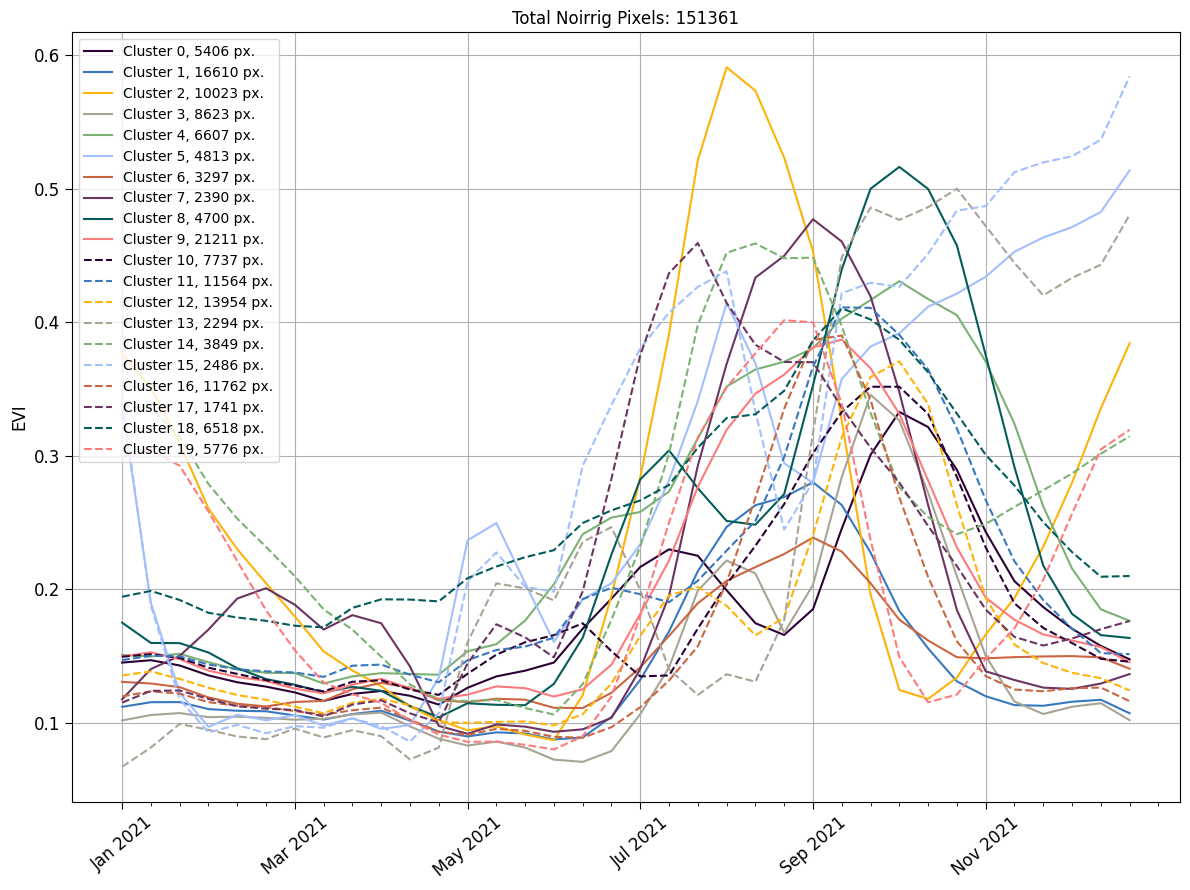

Which clusters should be discarded?
(Enter integers separated by a space or n for none)n
Sample change: 109972 --> 109972
Sample change: 24270 --> 24270
Sample change: 17119 --> 17119


In [ ]:
'''Execute clean_clusters() function.

Input is either 'raw' to clean the raw timeseries, or 'cleaned' to further reduce
the already cleaned timeseries.
'''

clean_clusters(ts_type='cleaned', save_new=True)

#### Convert cleaned CSVs to TFRecords for training

In [ ]:
import tensorflow as tf

def save_as_tfrecords():
    prefix = f'cleaned_labeled_timeseries/csvs/BF/'

    # Load CSVs
    blobs = storage_client.list_blobs(bucket_name, prefix=prefix)
    cleaned_ts = [blob.name for blob in blobs if 'cleaned' in blob.name.split('/')[-1]]
    out_dir = f'gs://{bucket_name}/cleaned_labeled_timeseries/tfrecords/BF'

    configs_for_export = ['training', 'validation', 'testing']

    for ix, config in enumerate(configs):

        irrig_csv = [i for i in cleaned_ts if config in i and 'irrig' in i][0]
        noirrig_csv = [i for i in cleaned_ts if config in i and 'noirrig' in i][0]

        # Read CSVs
        irrig_ts = pd.read_csv(f'gs://{bucket_name}/{irrig_csv}', index_col=0).to_numpy()
        noirrig_ts = pd.read_csv(f'gs://{bucket_name}/{noirrig_csv}', index_col=0).to_numpy()

        # Multiple by 10000, convert to ints (legacy)
        irrig_ts = (10000*irrig_ts).astype(np.int16)
        noirrig_ts = (10000*noirrig_ts).astype(np.int16)

        # Append a column of 1s on noirrig ts, 2s on irrig ts to align with
        # other previously produced tfrecords
        irrig_ts = np.concatenate((irrig_ts, 2*np.ones((len(irrig_ts),1))), axis=1)
        noirrig_ts = np.concatenate((noirrig_ts, np.ones((len(noirrig_ts),1))), axis=1)

        ## Concatenate and shuffle
        combined_ts = np.concatenate((irrig_ts, noirrig_ts), axis=0)
        np.random.shuffle(combined_ts)

        # Write out
        config_exp = configs_for_export[ix]
        writer_file = f'{out_dir}/{config_exp}_irrigpx_{len(irrig_ts)}_noirrigpx_{len(noirrig_ts)}.tfrecord'
        writer = tf.io.TFRecordWriter(writer_file)

        print(f'Writing out tfrecord: {writer_file}')

        for kx, row in enumerate(combined_ts):
            features, label = row[0:-1], int(row[-1])
            if kx == 0:
                print(f'example feats: {features}')
                print(f'example label: {label}')

            example = tf.train.Example()
            features = features.astype(np.int16)

            example.features.feature["features"].int64_list.value.extend(features)
            example.features.feature["label"].int64_list.value.append(label)
            writer.write(example.SerializeToString())


In [ ]:
# Save cleaned CSVs as tfrecords
save_as_tfrecords()